In [1]:
import numpy as np 


import sys
import os

import jax
import jax.numpy as jnp 

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


from kltpicker_3d.alt_least_squares import alternating_least_squares_solver
from kltpicker_3d.tests.exp_spectrum import *
from kltpicker_3d.tests.gaussian_spectrum import * 
from kltpicker_3d.tests.rpsd_test_data import generate_gaussian_rpsd_data
from kltpicker_3d.tomogram import factorize_RPSD
from kltpicker_3d.utils import * 

import scipy
from scipy.special import legendre
import scipy.integrate as integrate

import sys
import os
sys.path.insert(0, os.path.abspath(".."))
#os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
jax.config.update("jax_platform_name", "cpu")

jax.default_backend()   

plt.rcParams.update({ 
    "axes.grid": True,
    "grid.alpha": 0.5
})

In [2]:
vect_spectrum_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor,
                                    in_axes=(0,None))

In [3]:
K = 200
N = 32
uniform_points, bins = generate_uniform_radial_sampling_points(N)
H, samples =  generate_gaussian_rpsd_data(K,N,0.1)
# It was pre-calculated to fir SNR of 0.1

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/tests/rpsd_test_data.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k] = sample[:N,:N,:N]


In [4]:
max_d = int(np.floor(N/3))  
samples = samples - jnp.mean(samples, axis=(1,2,3)).reshape(-1,1,1,1)
psds = vect_spectrum_estimation(samples,max_d)

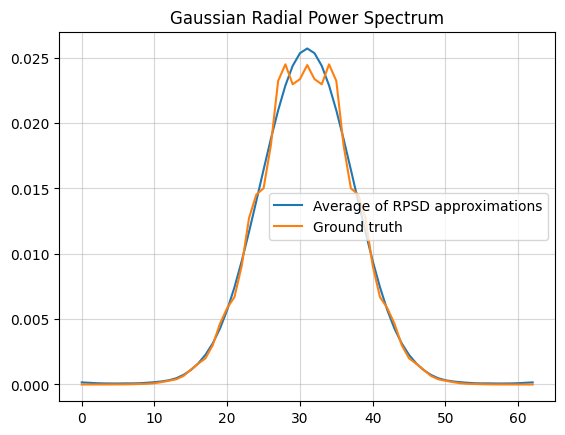

In [5]:
S = H / np.linalg.norm(H)
avg_psd = np.mean(psds,axis=0)
avg_psd /= np.linalg.norm(avg_psd)
plt.title("Gaussian Radial Power Spectrum")
plt.plot(avg_psd[N,N,:], label='Average of RPSD approximations')
plt.plot(S[N,N,:], label='Ground truth')
plt.legend();

In [6]:
def trigonometric_interpolation(x,y,z):
    """ 
    Vectorized trigonometric interpolation for equidistant points. 

    args:
        - x: equidistant sample points 
        - y: function values at sampled points
        - z: evaluation points for interpolation

    NOTE: The function is wrapped as vmap to process batches of sub-tomograms 
    hence there's no checking for parity of n and assumed it's always even.
    """
    n = x.shape[0]
    
    scale = (x[1] - x[0]) * n / 2 
    x_scaled = (x / scale) * jnp.pi / 2 
    z_scaled = (z / scale) * jnp.pi / 2

    delta = z_scaled[:, None] - x_scaled[None, :]

    # n always even 
    M = jnp.sin(n*delta) / (n *jnp.sin(delta))

    M = jnp.where(jnp.isclose(delta,0),1,M)

    p = M @ y 
    return p

def generate_legendre_points(n, a, b):
    """
    Get n leggauss points in interval [a, b]
    Parameters
    ----------
    n : int
        Number of points.
    a : float
        Interval starting point.
    b : float
        Interval end point.
    Returns
    -------
    x : numpy.ndarray
        Sample points.
    w : numpy.ndarray
        Weights.
    """
    x1, w = scipy.special.roots_legendre(n)
    m = (b - a) / 2
    c = (a + b) / 2
    x = m * x1 + c
    w = m * w
    x = np.flipud(x)
    return x, w

In [7]:
vect_inter = jax.vmap(trigonometric_interpolation,
                      in_axes=(None,0,None))

To preserve the variance of the original block we approximate the variance throuh $R[0,0]$ and scale the rblock approparietly. 

In [12]:
quad_order = 150
leg_points, w = generate_legendre_points(quad_order, -np.pi, np.pi)

## 3D grid to approximate the integral of the psd.
i,j,k = np.meshgrid(leg_points,leg_points,leg_points)
rho_tensor = (i**2 + j**2 + k**2) ** 0.5 
rho_tensor = np.where(rho_tensor > np.pi,0, rho_tensor)
rho, idx = np.unique(rho_tensor, return_inverse=True)


rblocks = np.array([radial_average(psds[k], bins, N) for k in range(K)])
# blocks_var = jnp.var(samples,axis=(1,2,3),ddof=1)

# psds_grid = vect_inter(jnp.pi*uniform_points, rblocks, rho)
# batched_psds_tensors = psds_grid[:,idx].reshape(K,
#                                                 quad_order,
#                                                 quad_order,
#                                                 quad_order)

# batch_vars = (1/(2*jnp.pi)**3) * jnp.einsum("bijk,i,j,k->b",
#                                          batched_psds_tensors,
#                                          w,w,w)

# scalings = blocks_var / batch_vars
# rblocks_s = scalings[:,None] * rblocks

In [13]:
factorization = alternating_least_squares_solver(rblocks,500,1e-4)

/tmp/ipykernel_1309916/2355446449.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


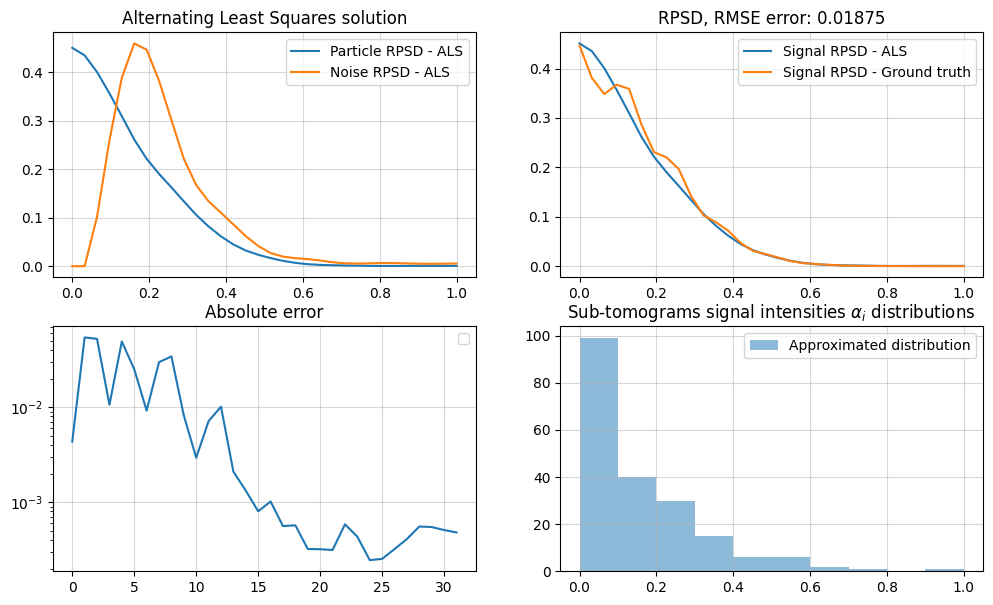

In [14]:
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)


fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average(H,bins,N)
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(uniform_points,particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(uniform_points,true_rpsd, label='Signal RPSD - Ground truth')
#ax[0,1].set_yscale('log')
ax[0,1].set_title("RPSD benchmark")
ax[0,1].set_title(f"RPSD, RMSE error: {np.sqrt(np.mean((true_rpsd - particle_psd)**2)):.5f}")
ax[0,1].legend()

ax[1,0].set_title("Absolute error")
ax[1,0].plot(np.abs(true_rpsd - particle_psd))
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].set_title(r"Sub-tomograms signal intensities $ \alpha_i$ distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].legend();

Rembmer the ALS solution is true up to constants that can be estimated from the noise variance.
In the following I show the derivation.

First to estimate $\sigma^2$ we average the smallest $25%$ variance patches (as they are likely to contain noise only). 
Now that we have the ALS solution $S_i = \alpha_i P + N$ we want the variance of the noise to be $\sigma^2$ that we estimated.

Note that for the following we use the followning observation;
Let $x$ be a zero-mean random process. By Weiner-Khinchin:

$$ R(\tau) = \frac{1}{(2\pi )^3} \int S(\omega)e^{i \langle \omega, \tau \rangle} d\omega$$

Letting $\tau=0$ we have that:

$$ R(0) = \frac{1}{(2\pi )^3} \int S(\omega) d\omega$$

But $R(0)=\mathbb{E}[x^2] = \text{Var}[x]$ for zero-mean signal.

Using the above we estimate the variance of the noise by $\int N(w) d\omega$ and we want it to be equal to $\sigma^2$. However as it was extracted using ALS it might be that there's still contribution of the particle PSD in it. So we are solving for:

$$ \int N(\omega) - \lambda P(\omega) d\omega = (2 \pi)^{3} \sigma^{2}$$

To make sure it matches the expected variance. 

Denote $\hat{s}(\omega) = \sum_{k=1}^K s(\omega)$ we want:

$$ \int P d \omega = \int \hat{s} d \omega - \sigma^2$$

So we define the scaling factor to be: $$ \frac{\int \hat{s} - \sigma^2}{\int P}$$

In [23]:
var_blocks = np.var(samples,axis=(1,2,3) ,ddof=1)
sorted_var = np.sort(var_blocks)
j = np.floor(0.25 * sorted_var.size).astype('int')
noise_var_approx = np.mean(sorted_var[:j])

quad_order = 150
leg_points, w = generate_legendre_points(quad_order, -np.pi, np.pi)

## 3D grid to approximate the integral of the psd.
i,j,k = np.meshgrid(leg_points,leg_points,leg_points)
rho_tensor = (i**2 + j**2 + k**2) ** 0.5 
rho_tensor = np.where(rho_tensor > np.pi,0, rho_tensor)
rho, idx = np.unique(rho_tensor, return_inverse=True)

# Interpolated particle and noise RPSD into 3D grid
clean_psd_tensor = np.abs(trigonometric_interpolation(uniform_points * np.pi, particle_psd, rho))
noise_psd_tensor = np.abs(trigonometric_interpolation(uniform_points * np.pi, noise_psd, rho))
clean_psd_tensor = np.reshape(clean_psd_tensor[idx], (quad_order,quad_order,quad_order))
noise_psd_tensor = np.reshape(noise_psd_tensor[idx], (quad_order,quad_order,quad_order))

gamma = jnp.einsum("ijk,i,j,k->", noise_psd_tensor,w,w,w) - (2*jnp.pi)**3 * noise_var_approx 
gamma /= jnp.einsum("ijk,i,j,k->", clean_psd_tensor,w,w,w)
fixed_noise_psd = noise_psd - gamma * particle_psd
fixed_noise_psd = gamma.clip(min=0,max=None)

In [ ]:
rpsd_mean = np.mean(rblocks,axis=0)
rpsd_mean_tensor = np.abs(trigonometric_interpolation(uniform_points*np.pi, rpsd_mean, rho))
rpsd_mean_tensor = np.reshape(rpsd_mean_tensor[idx], (quad_order,quad_order, quad_order))

rpsd_mean_var = (1/(2*np.pi)**3) * np.einsum("ijk,i,j,k->", rpsd_mean_tensor,w,w,w)
clean_psd_var = (1/(2*np.pi)**3) * np.einsum("ijk,i,j,k->", clean_psd_tensor,w,w,w)

clean_var = rpsd_mean_var - noise_var_approx
scaling_factor = clean_var / clean_psd_var  

clean_psd = scaling_factor * particle_psd 
noise_psd = fixed_noise_psd
noise_var = noise_var_approx